# Competition Objective is to detect fraud in transactions; 

## Data


In this competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target ```isFraud```.

The data is broken into two files **identity** and **transaction**, which are joined by ```TransactionID```. 

> Note: Not all transactions have corresponding identity information.

**Transaction variables**

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

**Categorical Features - Transaction**

- ProductCD
- emaildomain
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

**Categorical Features - Identity**

- DeviceType
- DeviceInfo
- id_12 - id_38

**The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).**


# 1. Importation and memory reduction
## 1.1. Importing necessary libraries

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


# Standard plotly imports
#import plotly.plotly as py
import plotly.graph_objs as go
import ipywidgets
import plotly.express as px
import plotly.tools as tls
from plotly.subplots import make_subplots

from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff


# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
#cufflinks.go_offline(connected=True)

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, GridSearchCV
from xgboost import XGBClassifier
import xgboost as xgb
import catboost as cb

## Hyperopt modules
from functools import partial

import os
import gc
import time

In [2]:
!jupyter nbextension enable --py widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


## 1.2. Importing train datasets

In [3]:
gc.collect()
df_train = pd.read_pickle("/kaggle/input/fraud-detection/df_train_v2.pkl")
df_test = pd.read_pickle("/kaggle/input/fraud-detection/df_test_v2.pkl")
sample_submission = pd.read_csv('/kaggle/input/fraud-detection/sample_submission.csv')

In [4]:
print(df_train.shape)
print(df_test.shape)

(590540, 430)
(506691, 429)


## 1.3. Memory reduction

In [5]:
def resumetable(df):
    n = df.shape[0]
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values  
    summary['Missing %'] = round(summary['Missing'] / n * 100,2)
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values


    return summary


To see the output of the Resume Table, click to see the output 

# 2. Preprocessing

In [6]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_37,id_38,DeviceType,DeviceInfo,_merge,dist1_na,dist2_na,_Weekdays,_Hours,_Days
0,2987000,0,86400,4.226562,W,13926,-inf,150,discover,142,...,T,T,mobile,Others,both,False,True,5,0,2
1,2987001,0,86401,3.367188,W,2755,404,150,mastercard,102,...,F,T,mobile,iOS Device,both,True,True,5,0,2
2,2987002,0,86469,4.078125,W,4663,490,150,visa,166,...,T,T,desktop,Windows,both,False,True,5,0,2
3,2987003,0,86499,3.912109,W,18132,567,150,mastercard,117,...,T,T,desktop,Windows,both,True,True,5,0,2
4,2987004,0,86506,3.912109,H,4497,514,150,mastercard,102,...,T,T,desktop,MacOS,both,True,True,5,0,2


In [7]:
categorical_features = []
for col in df_train.columns.drop('isFraud') :
    if (df_train[col].dtype == 'object' 
        or df_test[col].dtype=='object' 
        or df_train[col].dtype == 'bool') :
        categorical_features.append(col)
categorical_features.extend(['_merge', '_Weekdays',	'_Hours',	'_Days'])

In [8]:
categorical_resume = resumetable(df_train[categorical_features])
categorical_resume

Dataset Shape: (590540, 42)


,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value
0,ProductCD,object,0,0.0,5,W,W,W
1,card1,object,0,0.0,13553,13926,2755,4663
2,card2,object,0,0.0,501,-inf,404,490
3,card3,object,0,0.0,115,150,150,150
4,card4,object,0,0.0,5,discover,mastercard,visa
5,card5,object,0,0.0,120,142,102,166
6,card6,object,0,0.0,5,credit,credit,debit
7,addr1,object,0,0.0,333,315,325,330
8,addr2,object,0,0.0,75,87,87,87
9,P_emaildomain,object,0,0.0,31,gmail.com,gmail.com,outlook.com


In [9]:
# Label Encoding
categorical_features_v2 = categorical_features.copy()
for f in categorical_features:
    if float(categorical_resume.loc[categorical_resume['Name']==f, 'Uniques']) > 8 :
        categorical_features_v2.remove(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_train[f].values) + list(df_test[f].values))
        df_train[f] = lbl.transform(list(df_train[f].values))
        df_test[f] = lbl.transform(list(df_test[f].values))  

In [10]:
categorical_resume_v2 = resumetable(df_train[categorical_features_v2])
categorical_resume_v2

Dataset Shape: (590540, 30)


,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value
0,ProductCD,object,0,0.0,5,W,W,W
1,card4,object,0,0.0,5,discover,mastercard,visa
2,card6,object,0,0.0,5,credit,credit,debit
3,M1,object,0,0.0,3,T,Miss,T
4,M2,object,0,0.0,3,T,Miss,T
5,M3,object,0,0.0,3,T,Miss,T
6,M4,object,0,0.0,4,M2,M0,M0
7,M5,object,0,0.0,3,F,T,F
8,M6,object,0,0.0,3,T,T,F
9,M7,object,0,0.0,3,Miss,Miss,F


In [11]:
Y_train = df_train['isFraud']
df_train.drop(['isFraud','TransactionID'], axis = 1, inplace = True)
df_test.drop('TransactionID', axis = 1, inplace = True)

In [12]:
categorical_index = [df_train.columns.get_loc(key) for key in categorical_features_v2]


# 3. Modeling

## 3.1. Catboost with defaut parameters

In [13]:
train = cb.Pool(df_train, Y_train, cat_features=categorical_index)
test = cb.Pool(df_test, cat_features=categorical_index)
del df_train, Y_train, df_test
gc.collect()


0

In [14]:
params = {'depth': [15],
          'learning_rate' : [0.03],
         'l2_leaf_reg': [3],
         'iterations': [1000]}

cb_model = cb.CatBoostClassifier(eval_metric="AUC", 
                                 one_hot_max_size= 8, 
                                 task_type="GPU",
                                 devices='0:1',
                                 depth = 12,
                                 learning_rate= 0.03,
                                 l2_leaf_reg = 3,
                                 iterations = 1000)
cb_model.fit(train, plot = True, verbose = False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### 3.1.1. Variable importances analysis 

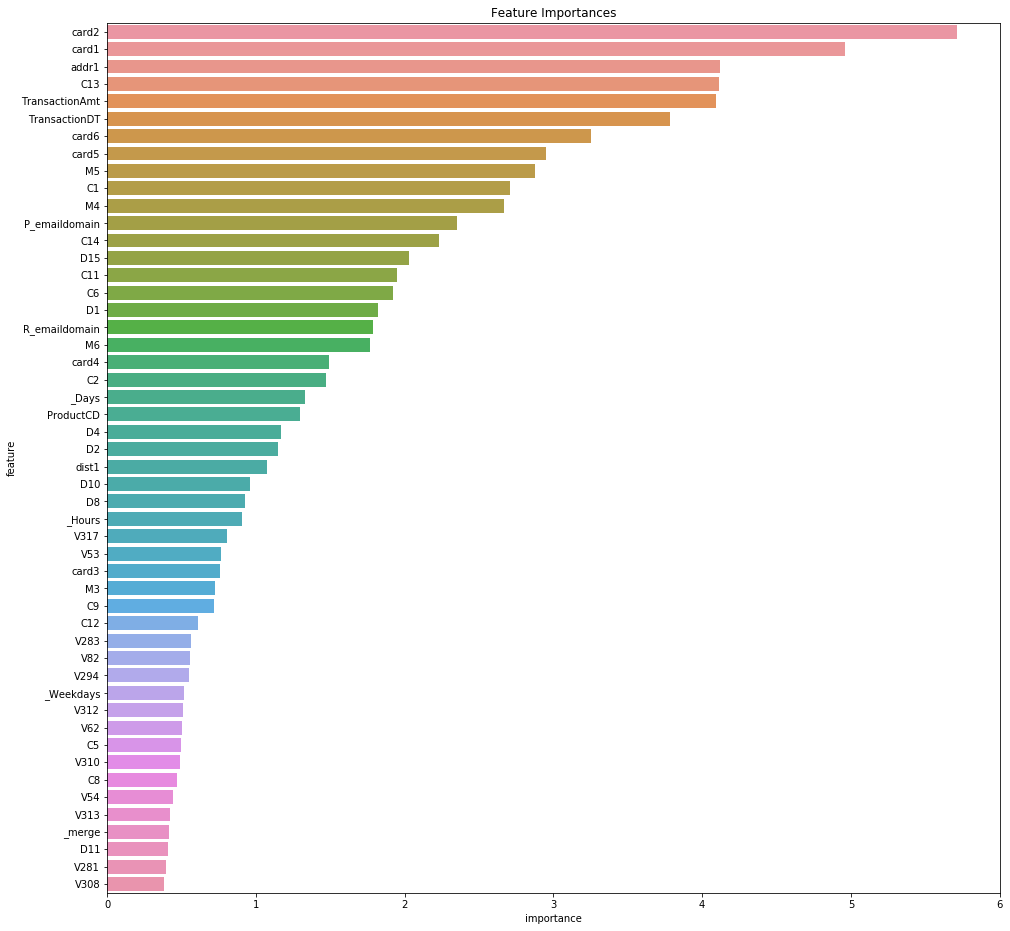

In [15]:
feature_imp = pd.DataFrame([train.get_feature_names(), cb_model.get_feature_importance()],index= ['feature', 'importance']).T
feature_imp_top50 = feature_imp.sort_values(by='importance', ascending=False).iloc[0:50]

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_imp_top50, x='importance', y='feature')
plt.title('Feature Importances')  
plt.show()

In [17]:
stat_top10fea = cb_model.calc_feature_statistics(train,
                                                 feature = feature_imp_top50['feature'].tolist()[0:10],
                                                 prediction_type='Probability',
                                                 plot=True
                                  )

In [18]:
params_cv = {'depth': 12,
             'learning_rate' : 0.03,
             'l2_leaf_reg': 3,
             'loss_function': "Logloss", 
             'eval_metric' : 'AUC',
             'iterations': 500}
scores = cb.cv(train,
               params_cv,
               fold_count=3,
               stratified=True,
               
               plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7174291	best: 0.7174291 (0)	total: 45.7s	remaining: 6h 19m 58s
1:	test: 0.7525184	best: 0.7525184 (1)	total: 1m 26s	remaining: 5h 58m 17s
2:	test: 0.7717113	best: 0.7717113 (2)	total: 2m 5s	remaining: 5h 47m 49s
3:	test: 0.7924157	best: 0.7924157 (3)	total: 2m 43s	remaining: 5h 37m 31s
4:	test: 0.8129042	best: 0.8129042 (4)	total: 3m 23s	remaining: 5h 35m 52s
5:	test: 0.8228247	best: 0.8228247 (5)	total: 4m 5s	remaining: 5h 36m 29s
6:	test: 0.8300424	best: 0.8300424 (6)	total: 4m 46s	remaining: 5h 36m 6s
7:	test: 0.8330129	best: 0.8330129 (7)	total: 5m 20s	remaining: 5h 28m 9s
8:	test: 0.8329510	best: 0.8330129 (7)	total: 6m 1s	remaining: 5h 28m 46s
9:	test: 0.8316472	best: 0.8330129 (7)	total: 6m 37s	remaining: 5h 24m 49s
10:	test: 0.8325775	best: 0.8330129 (7)	total: 7m 10s	remaining: 5h 18m 35s
11:	test: 0.8317730	best: 0.8330129 (7)	total: 7m 47s	remaining: 5h 17m 5s
12:	test: 0.8352033	best: 0.8352033 (12)	total: 8m 24s	remaining: 5h 15m 13s
13:	test: 0.8370525	best: 0.

### 3.1.2. Training with Cross Validation 

In [ ]:
params_cv = {'depth': 12,
             'learning_rate' : 0.03,
             'l2_leaf_reg': 3,
             'loss_function': "Logloss", 
             'eval_metric' : 'AUC',
             'iterations': 800}
score = cb.cv(train,
              params_cv,
              fold_count=3,
              stratified=True,
              plot=True,
              verbose = False)

In [15]:
cv_score = pd.read_pickle('cv_score.pkl')
cv_score

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.717429,0.041249,0.642048,0.001161,0.642039,0.001177
1,1,0.752518,0.009147,0.596267,0.000964,0.596257,0.000965
2,2,0.771711,0.017920,0.554137,0.002232,0.554118,0.002233
3,3,0.792416,0.014776,0.515164,0.002024,0.515152,0.001950
4,4,0.812904,0.011881,0.479317,0.001050,0.479282,0.001029
5,5,0.822825,0.011549,0.446834,0.000997,0.446789,0.001061
6,6,0.830042,0.009364,0.417707,0.001016,0.417667,0.000960
7,7,0.833013,0.008565,0.391933,0.000321,0.391873,0.000255
8,8,0.832951,0.008564,0.367658,0.000578,0.367588,0.000474
9,9,0.831647,0.008154,0.346156,0.001081,0.346075,0.001001


In [72]:
def plot_ic(x, y, y_upper, y_lower, title_text, color = 'green', legend = False) : 
    x = list(x)
    y = list(y)
    y_upper = list(y_upper)
    y_lower = list(y_lower)
    y_lower = y_lower[::-1]
    x_rev = x[::-1]
    if legend ==False : 
        show_legend = False
        legend = ''
    else : show_legend = True
    
    if color == 'green' :
        color1 = 'rgb(194,243,187)'
        color2 = 'rgb(111,226,95)'
    elif color == 'blue':
        color1 = 'rgb(221,236,254)'
        color2 = 'rgb(62,65,255)'
    trace1 = go.Scatter(
        x=x+x_rev,
        y=y_upper+y_lower,
        fill='tozerox',
        fillcolor=color1,
        line=dict(color=color2, width = 1),
        showlegend=False,
    )

    trace2 = go.Scatter(
        x=x,
        y=y,
        line=dict(color=color2),
        mode='lines',
        showlegend = show_legend,
        name = legend
    )

    data = [trace1, trace2]

    layout = go.Layout(title = title_text,
        xaxis=dict(
            gridcolor='rgb(255,255,255)',
            showgrid=True,
            showline=False,
            showticklabels=True,
            tickcolor='rgb(127,127,127)',
            ticks='outside',
        ),
        yaxis=dict(
            gridcolor='rgb(255,255,255)',
            showgrid=True,
            showline=False,
            showticklabels=True,
            tickcolor='rgb(127,127,127)',
            ticks='outside',
        ),
    )
    return data, layout

In [73]:
data, layout = plot_ic(cv_score['iterations'], cv_score['test-AUC-mean'], 
                        cv_score['test-AUC-mean'] + 1.96*cv_score['test-AUC-std'],
                        cv_score['test-AUC-mean'] - 1.96*cv_score['test-AUC-std'],
                        'AUC on validation set'
                       )
go.Figure(data=data, layout=layout)


In [79]:
data1, layout = plot_ic(cv_score['iterations'], cv_score['test-Logloss-mean'], 
                        cv_score['test-Logloss-mean'] + 1.96*cv_score['test-Logloss-std'],
                        cv_score['test-Logloss-mean'] - 1.96*cv_score['test-Logloss-std'],
                        'Logloss', legend = 'on validation set'
                       )
data2, layout = plot_ic(cv_score['iterations'], cv_score['train-Logloss-mean'], 
                        cv_score['train-Logloss-mean'] + 1.96*cv_score['train-Logloss-std'],
                        cv_score['train-Logloss-mean'] - 1.96*cv_score['train-Logloss-std'],
                        'Logloss', legend = 'on train set', color = 'blue'
                       )
go.Figure(data=data1+data2, layout=layout)